# HW3: CNN

This is the example code of homework 3 of the machine learning course by Prof. Hung-yi Lee.

In this homework, you are required to build a convolutional neural network for image classification, possibly with some advanced training tips.


There are three levels here:

**Easy**: Build a simple convolutional neural network as the baseline. (2 pts) 搭建一个简单的卷积神经网络作为基线模型。

**Medium**: Design a better architecture or adopt different data augmentations to improve the performance. (2 pts) 设计更优的网络结构，或采用不同的数据增强方法以提升性能。

**Hard**: Utilize provided unlabeled data to obtain better results. (2 pts) 利用提供的无标签数据获得更好的结果。

**About the Dataset**：

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data.
Please DO NOT access the original fully-labeled training data or testing labels.

Also, the modified dataset is for this course only, and any further distribution or commercial use is forbidden.

In [1]:
# HomeworkID
HOMEWORK_ID = "hw3"
# Res Directory
RES_DIR = f"res/{HOMEWORK_ID}/"
# Output Directory
OUTPUT_DIR = f"output/{HOMEWORK_ID}/"
# Random Seed
RANDOM_SEED = 42

In [2]:
# Import packages

# Standard libraries
import os
import csv
import random
import numpy as np
import gc

# Pytorch and Keras
import torch
import keras
from keras import layers
import tensorflow as tf

# For plotting
import matplotlib.pyplot as plt

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
# Utilities
def get_device():
    ''' Returns the available device: GPU if available, else CPU '''
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_random_seed(seed_value=RANDOM_SEED):
    ''' Sets the random seed for reproducibility '''
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True # 强制CuDNN使用确定性算法
        torch.backends.cudnn.benchmark = False # 关闭CuDNN的自动优化功能

def plot_learning_curve(loss_record: dict, title: str):
    """Plots the learning curve"""
    total_epochs = len(loss_record["loss"])
    x_train = np.arange(1, total_epochs + 1)
    
    if len(loss_record["val_loss"]) > 0:
        x_val = x_train[:: max(1, len(x_train) // len(loss_record["val_loss"]))]
        x_val = x_val[:len(loss_record["val_loss"])]
    else:
        x_val = []
    
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(x_train, loss_record["loss"], c="tab:red", label="Training Loss", linewidth=2)
    if len(x_val) > 0:
        plt.plot(x_val, loss_record["val_loss"], c="tab:blue", label="Validation Loss", linewidth=2)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Loss Curve", fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    if "accuracy" in loss_record:
        plt.plot(x_train, loss_record["accuracy"], c="tab:green", label="Training Accuracy", linewidth=2)
    if "val_accuracy" in loss_record and len(x_val) > 0:
        plt.plot(x_val, loss_record["val_accuracy"], c="tab:orange", label="Validation Accuracy", linewidth=2)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Accuracy Curve", fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' ', '_')}.png"), dpi=150)
    plt.show()

def clear_memory():
    """清理内存"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [4]:
# GPU Checking
print(f"{'='*40}")
print(f"Using device: {get_device()}")
print(f"PyTorch version: {torch.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Current Backend: {keras.backend.backend()}")
print(f"{'='*40}")

# Set random seed for reproducibility
set_random_seed(RANDOM_SEED)
print(f"Random seed set to: {RANDOM_SEED}")
print(f"{'='*40}")

# Make sure OUTPUT_DIR exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

Using device: cuda
PyTorch version: 2.9.1+cu130
Keras Version: 3.13.0
Current Backend: torch
Random seed set to: 42


## **Dataset**

In [5]:
# trainData Labeled
TRAIN_DATA_LABELED = os.path.join(RES_DIR, "training", "labeled")
# trainData Unlabeled
TRAIN_DATA_UNLABELED = os.path.join(RES_DIR, "training", "unlabeled")
# validation Data
VALIDATION_DATA = os.path.join(RES_DIR, "validation")
# test Data
TEST_DATA = os.path.join(RES_DIR, "testing")

## **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers. 这里的基础模型结构十分简单，由堆叠的卷积层与后续的若干全连接层构成。

Since there are three channels for a color image (RGB), the input channels of the network must be three. 由于彩色图像包含红、绿、蓝三个通道（RGB），网络的输入通道数必须设为 3。
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding). 在每个卷积层中，输入的通道数通常会增加，而特征图的高度和宽度则会缩小（也可根据步长、填充等超参数设置保持不变）

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class. 在将特征图送入全连接层之前，必须将其展平为一维向量（单张图像对应一个一维向量）。随后，这些特征会经由全连接层完成变换，最终得到每个类别的逻辑预测值（logits）。

### **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**)  → This is **NOT** allowed.

In [6]:
def create_model(
    input_shape=(128, 128, 3),
    num_classes=11,
    cnn_filters=[64, 128, 256, 512],
    dense_units=[512, 256],
    dropout_rate=0.3
):
    """
    改进的 CNN 模型
    - 更深的网络
    - Squeeze-and-Excitation (SE) 注意力机制
    - 更好的正则化
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # Data Augmentation
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
    ], name="augmentation")
    
    x = data_augmentation(x)
    
    # Normalization
    x = layers.Rescaling(1.0 / 255)(x)
    
    # Initial Conv Block
    x = layers.Conv2D(64, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    # Residual Blocks with SE Attention
    for i, filters in enumerate(cnn_filters):
        # Residual block
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        # Squeeze-and-Excitation (SE) Block
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(filters // 16, activation="relu")(se)
        se = layers.Dense(filters, activation="sigmoid")(se)
        se = layers.Reshape((1, 1, filters))(se)
        x = layers.Multiply()([x, se])
        
        # Downsampling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        # Residual connection
        residual = layers.Conv2D(filters, 1, strides=2, padding="same", use_bias=False)(
            previous_block_activation
        )
        residual = layers.BatchNormalization()(residual)
        x = layers.add([x, residual])
        
        previous_block_activation = x
    
    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers with dropout
    for units in dense_units:
        x = layers.Dense(units, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs, name="improved_cnn")
    
    return model

## **数据集创建工具**

In [16]:
def create_dataset_from_arrays(images, labels, batch_size=32, shuffle=True, augment=False):
    """
    从 NumPy 数组创建 TensorFlow Dataset
    """
    # 创建基础数据集
    if labels is not None:
        dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    else:
        # 无标签数据，创建假标签
        fake_labels = np.zeros(len(images), dtype=np.int32)
        dataset = tf.data.Dataset.from_tensor_slices((images, fake_labels))
    
    # 打乱
    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(10000, len(images)), seed=RANDOM_SEED)
    
    # 数据增强
    if augment:
        def augment_fn(image, label):
            # 随机水平翻转
            image = tf.image.random_flip_left_right(image)
            
            # 随机亮度
            image = tf.image.random_brightness(image, max_delta=0.2)
            
            # 随机对比度
            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
            
            # 随机饱和度
            image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
            
            # 裁剪范围内
            image = tf.clip_by_value(image, 0, 255)
            
            return image, label
        
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 批处理和预取
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

## **伪标签训练（Semi-Supervised Learning）**

In [8]:
def generate_pseudo_labels(model, unlabeled_ds, confidence_threshold=0.9):
    """生成高置信度的伪标签"""
    print(f"\n正在生成伪标签（置信度阈值: {confidence_threshold}）...")
    
    pseudo_images = []
    pseudo_labels = []
    total_samples = 0
    
    # 分批处理，避免内存累积
    batch_count = 0
    for images, _ in unlabeled_ds:
        # 转换为 NumPy 并预测
        images_np = images.numpy()
        predictions = model.predict(images_np, verbose=0, batch_size=32)
        
        max_probs = np.max(predictions, axis=1)
        pred_labels = np.argmax(predictions, axis=1)
        
        # 只保留高置信度的预测
        high_conf_mask = max_probs >= confidence_threshold
        total_samples += len(images_np)
        
        if np.any(high_conf_mask):
            pseudo_images.append(images_np[high_conf_mask])
            pseudo_labels.append(pred_labels[high_conf_mask])
        
        batch_count += 1
        if batch_count % 10 == 0:
            print(f"  已处理 {batch_count} 批次...")
    
    if pseudo_images:
        pseudo_images = np.concatenate(pseudo_images, axis=0)
        pseudo_labels = np.concatenate(pseudo_labels, axis=0)
        
        print(f"  总无标签样本: {total_samples}")
        print(f"  生成伪标签: {len(pseudo_labels)} ({len(pseudo_labels)/total_samples*100:.1f}%)")
        print(f"  标签分布: {np.bincount(pseudo_labels, minlength=11)}")
        
        return pseudo_images, pseudo_labels
    else:
        print("  没有生成任何伪标签")
        return None, None

In [9]:
def train_with_pseudo_labeling(
    model,
    labeled_ds,
    unlabeled_ds,
    validation_ds,
    epochs=100,
    confidence_threshold=0.9,
    initial_epochs=30,
    batch_size=32,
):
    """
    三阶段伪标签训练 - 增强版
    """
    
    # 设置 CUDA 错误检查
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    
    # ===== 阶段 1: 初始训练 =====
    print("\n" + "=" * 60)
    print("阶段 1: 使用标签数据进行初始训练")
    print("=" * 60)
    
    callbacks_stage1 = [
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy", 
            patience=15, 
            restore_best_weights=True, 
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", 
            factor=0.5, 
            patience=5, 
            min_lr=1e-6, 
            verbose=1
        ),
    ]
    
    try:
        history1 = model.fit(
            labeled_ds,
            validation_data=validation_ds,
            epochs=initial_epochs,
            callbacks=callbacks_stage1,
            verbose=1,
        )
    except Exception as e:
        print(f"\n训练过程中出现错误: {e}")
        print("尝试清理内存并重试...")
        clear_memory()
        raise
    
    clear_memory()
    
    # 评估初始模型
    val_loss, val_acc = model.evaluate(validation_ds, verbose=0)
    print(f"\n初始模型验证准确率: {val_acc:.4f}")
    
    # ===== 阶段 2: 生成伪标签 =====
    print("\n" + "=" * 60)
    print("阶段 2: 生成伪标签")
    print("=" * 60)
    
    pseudo_images, pseudo_labels = generate_pseudo_labels(
        model, unlabeled_ds, confidence_threshold
    )
    
    clear_memory()
    
    if pseudo_images is None:
        print("没有生成伪标签，跳过阶段 3")
        return history1
    
    # ===== 阶段 3: 混合训练 =====
    print("\n" + "=" * 60)
    print("阶段 3: 使用标签数据 + 伪标签数据训练")
    print("=" * 60)
    
    # 收集标签数据 - 分批处理
    print("收集标签数据...")
    labeled_images = []
    labeled_labels = []
    
    for images, labels in labeled_ds:
        labeled_images.append(images.numpy())
        labeled_labels.append(labels.numpy())
    
    labeled_images = np.concatenate(labeled_images, axis=0)
    labeled_labels = np.concatenate(labeled_labels, axis=0)
    
    print(f"\n数据统计:")
    print(f"  标签数据: {len(labeled_images)} 样本")
    print(f"  伪标签数据: {len(pseudo_images)} 样本")
    
    # 合并数据
    combined_images = np.concatenate([labeled_images, pseudo_images], axis=0)
    combined_labels = np.concatenate([labeled_labels, pseudo_labels], axis=0)
    
    # 清理中间变量
    del labeled_images, labeled_labels, pseudo_images, pseudo_labels
    clear_memory()
    
    # 创建新的数据集 - 不使用增强（已在模型中）
    print("创建混合数据集...")
    combined_ds = create_dataset_from_arrays(
        combined_images,
        combined_labels,
        batch_size=batch_size,
        shuffle=True
    )
    
    # 清理
    del combined_images, combined_labels
    clear_memory()
    
    # 继续训练
    callbacks_stage3 = [
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy", 
            patience=20, 
            restore_best_weights=True, 
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", 
            factor=0.5, 
            patience=7, 
            min_lr=1e-7, 
            verbose=1
        ),
    ]
    
    try:
        history2 = model.fit(
            combined_ds,
            validation_data=validation_ds,
            epochs=epochs - initial_epochs,
            callbacks=callbacks_stage3,
            verbose=1,
        )
    except Exception as e:
        print(f"\n阶段3训练过程中出现错误: {e}")
        print("返回阶段1的结果...")
        return history1
    
    clear_memory()
    
    # 合并历史
    for key in history1.history:
        if key in history2.history:
            history1.history[key].extend(history2.history[key])
    
    # 最终评估
    val_loss, val_acc = model.evaluate(validation_ds, verbose=0)
    print(f"\n最终模型Loss: {val_loss:.4f} 最终模型验证准确率: {val_acc:.4f}")
    
    return history1

## **主训练流程**

In [ ]:
# Hyperparameters
USE_PSEUDO_LABELING = True      # 使用伪标签训练
# 模型超参数
batch_size = 32
image_size = (128, 128)
cnn_filters = [64, 128, 256, 512]  # 更深的网络
dense_units = [256, 128]            # 更大的全连接层
epochs = 100
learning_rate = 1e-3
weight_decay = 1e-5
dropout_rate = 0.3
# 伪标签超参数
confidence_threshold = 0.90  # 伪标签置信度阈值
initial_epochs = 40          # 初始训练轮数
# TTA 超参数
n_tta_augmentations = 5

In [12]:
# Load datasets
print("\n加载数据集...")
train_labeled_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DATA_LABELED,
    batch_size=batch_size,
    image_size=image_size,
    seed=RANDOM_SEED,
    shuffle=True,
)
print(f"✓ 已加载标签训练数据")

train_unlabeled_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DATA_UNLABELED,
    batch_size=batch_size,
    image_size=image_size,
    seed=RANDOM_SEED,
    shuffle=True,
)
print(f"✓ 已加载无标签训练数据")

validation_ds = keras.utils.image_dataset_from_directory(
    VALIDATION_DATA,
    batch_size=batch_size,
    image_size=image_size,
    seed=RANDOM_SEED,
    shuffle=True,
)
print(f"✓ 已加载验证数据")

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DATA,
    batch_size=batch_size,
    image_size=image_size,
    seed=RANDOM_SEED,
    shuffle=False,
)
print(f"✓ 已加载测试数据")

# 数据预取优化
train_labeled_ds = train_labeled_ds.prefetch(buffer_size=2)
validation_ds = validation_ds.prefetch(buffer_size=2)
test_ds = test_ds.prefetch(buffer_size=2)

clear_memory()


加载数据集...
Found 3080 files belonging to 11 classes.
✓ 已加载标签训练数据
Found 6786 files belonging to 1 classes.
✓ 已加载无标签训练数据
Found 660 files belonging to 11 classes.
✓ 已加载验证数据
Found 3347 files belonging to 1 classes.
✓ 已加载测试数据


In [13]:
# Create model
print("\n创建模型...")
model = create_model(
    input_shape=(image_size[0], image_size[1], 3),
    num_classes=11,
    cnn_filters=cnn_filters,
    dense_units=dense_units,
    dropout_rate=dropout_rate
)
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"],)
print("\n模型结构:")
model.summary()


创建模型...



模型结构:


Model: "improved_cnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ augmentation[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,728 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 64, 64,    │      4,672 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 64, 64,    │      4,672 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,096 │ activation[0][0]

 Total params: 938,503 (3.58 MB)

 Trainable params: 931,847 (3.55 MB)

 Non-trainable params: 6,656 (26.00 KB)


阶段 1: 使用标签数据进行初始训练
Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.1825 - loss: 2.4449 - val_accuracy: 0.0909 - val_loss: 2.6551 - learning_rate: 0.0010
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.2237 - loss: 2.2195 - val_accuracy: 0.0924 - val_loss: 2.7788 - learning_rate: 0.0010
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.2438 - loss: 2.1622 - val_accuracy: 0.1076 - val_loss: 2.8311 - learning_rate: 0.0010
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.2695 - loss: 2.0539 - val_accuracy: 0.0955 - val_loss: 2.9223 - learning_rate: 0.0010
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.2955 - loss: 2.0010 - val_accuracy: 0.1136 - val_loss: 2.8122 - learning_rate: 0.0010
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 0.3143 - loss: 1.9240 - val_accuracy: 0.2000 - val_loss: 2.2040 - learning_rate: 0.0010
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - accurac

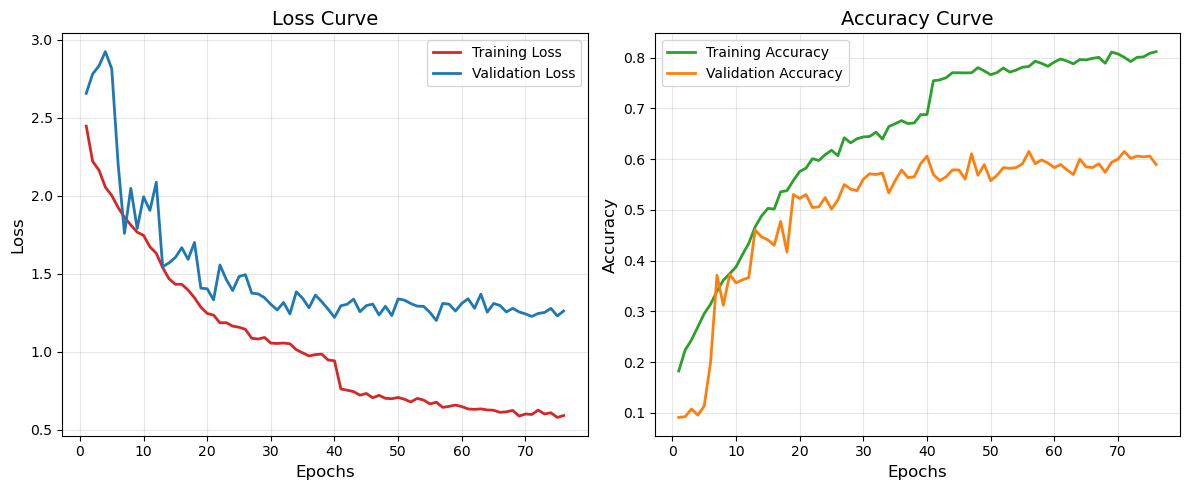

In [14]:
# ===== 训练 =====
if USE_PSEUDO_LABELING:
    # 伪标签训练
    history = train_with_pseudo_labeling(
        model,
        train_labeled_ds,
        train_unlabeled_ds,
        validation_ds,
        epochs=epochs,
        confidence_threshold=confidence_threshold,
        initial_epochs=initial_epochs,
        batch_size=batch_size,
    )
else:
    # 标准训练
    print("\n" + "="*60)
    print("标准训练（仅使用标签数据）")
    print("="*60)
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
    ]
    
    history = model.fit(
        train_labeled_ds,
        validation_data=validation_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

clear_memory()

# 保存模型
model_name = f'model_final_lr{learning_rate}_dropout{dropout_rate}.keras'
model.save(os.path.join(OUTPUT_DIR, model_name))
print(f"\n✓ 模型已保存: {model_name}")

# 绘制学习曲线
plot_learning_curve(history.history, title="Training and Validation Curves")

## Testing

In [19]:
# Prediction
predictions = model.predict(test_ds)
    
# Save predictions to CSV
OUTPUT_CSV_PATH = os.path.join(OUTPUT_DIR, "predictions.csv")
with open(OUTPUT_CSV_PATH, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['id', 'label'])
    for i, pred in enumerate(predictions):
        predicted_label = np.argmax(pred)
        writer.writerow([i, predicted_label])
print(f"\n✓ 预测结果已保存到: {OUTPUT_CSV_PATH}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step

✓ 预测结果已保存到: output/hw3/predictions.csv



预测置信度统计:
  平均置信度: 0.7131
  中位数置信度: 0.7477
  最小置信度: 0.1533
  最大置信度: 1.0000

预测标签分布:
  类别 0: 289 (8.6%)
  类别 1: 144 (4.3%)
  类别 2: 340 (10.2%)
  类别 3: 281 (8.4%)
  类别 4: 296 (8.8%)
  类别 5: 462 (13.8%)
  类别 6: 248 (7.4%)
  类别 7: 220 (6.6%)
  类别 8: 317 (9.5%)
  类别 9: 400 (12.0%)
  类别 10: 350 (10.5%)


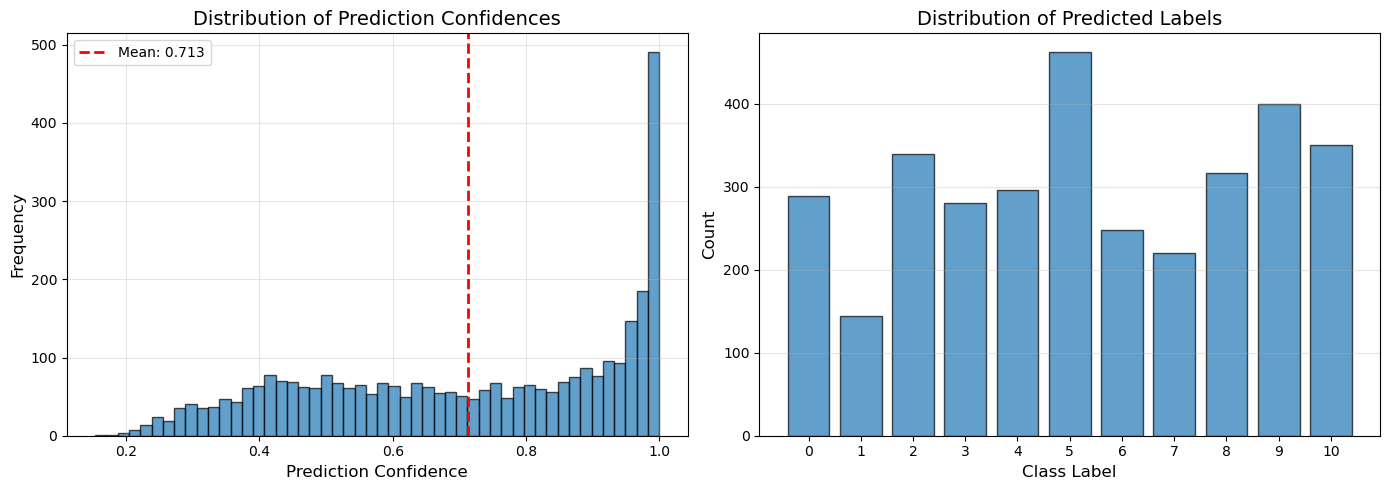


✓ 训练和预测完成！


In [20]:
# ===== 预测统计 =====
max_confidences = np.max(predictions, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

print(f"\n预测置信度统计:")
print(f"  平均置信度: {np.mean(max_confidences):.4f}")
print(f"  中位数置信度: {np.median(max_confidences):.4f}")
print(f"  最小置信度: {np.min(max_confidences):.4f}")
print(f"  最大置信度: {np.max(max_confidences):.4f}")

print(f"\n预测标签分布:")
label_counts = np.bincount(predicted_labels, minlength=11)
for i, count in enumerate(label_counts):
    print(f"  类别 {i}: {count} ({count/len(predictions)*100:.1f}%)")

# ===== 可视化 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 置信度分布
axes[0].hist(max_confidences, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(max_confidences), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(max_confidences):.3f}')
axes[0].set_xlabel("Prediction Confidence", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Distribution of Prediction Confidences", fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 标签分布
axes[1].bar(range(11), label_counts, edgecolor='black', alpha=0.7)
axes[1].set_xlabel("Class Label", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].set_title("Distribution of Predicted Labels", fontsize=14)
axes[1].set_xticks(range(11))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "prediction_analysis.png"), dpi=150)
plt.show()

print("\n" + "="*60)
print("✓ 训练和预测完成！")
print("="*60)